In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from ctypes import DEFAULT_MODE
import shap
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Florida State 2020 - 2023 Loan EDA

In [ ]:
file_24 = './2024_combined_mlar_header.txt'
df24 = pd.read_csv(file_24, delimiter='|')

In [89]:
df24.shape

(12229293, 85)

In [ ]:
file_23 = './state_FL2023.csv'
file_22 = './state_FL2022.csv'
file_21 = './state_FL2021.csv'
file_20 = './state_FL2020.csv'
df23 = pd.read_csv(file_23)
df22 = pd.read_csv(file_22)
df21 = pd.read_csv(file_21)
df20 = pd.read_csv(file_20)

# Approval By Race

First we map the race codes to race names as the first analysis to check for disparities at institue level not at state level

In [6]:
# Mapping of race codes to race names
race_mapping = {
    1.0: "American Indian/Alaska Native",
    2.0: "Asian",
    3.0: "Black or African American",
    4.0: "Native Hawaiian/Pacific Islander",
    5.0: "White",
    6.0: "Race Not Provided",
    7.0: "Not Applicable",
    21.0: "Free Form Text (Race 1)",
    22.0: "Free Form Text (Race 2)",
    23.0: "Free Form Text (Race 3)",
    24.0: "Free Form Text (Race 4)",
    25.0: "Free Form Text (Race 5)",
    26.0: "Two Races",
    27.0: "Three or More Races",
    41.0: "Joint (Race 1)",
    42.0: "Joint (Race 2)",
    43.0: "Joint (Race 3)",
    44.0: "Joint (Race 4)"}

Next we define a function to get approval to rejection ratio by race first at state and next at LEI (institute code) levels\
Action Taken:\
1 -- Loan originated \
2 -- Application approved but not accepted \
3 -- Application denied by financial institution\
4 -- Application withdrawn by applicant\
5 -- File closed for incompleteness\
6 -- Loan purchased by the institution\
7 -- Preapproval request denied by financial institution\
8 -- Preapproval request approved but not accepted (optional reporting)

## State Level

We first edit the applicant race column in 2024 dataset to match previous years

In [7]:
df24.rename(columns={'applicant_race_1': 'applicant_race-1'}, inplace=True)


In [8]:
def approval_ratio_race(df, dataset_name):
    approval_rejection_ratio_race = df.groupby('applicant_race-1').apply(
        lambda x: (x[x['action_taken'] == 1].shape[0] / max(1, x[x['action_taken'] == 3].shape[0]))
    ).reset_index(name='approval_to_rejection_ratio_race')
    approval_rejection_ratio_race['dataset'] = dataset_name  # dataset identifier
    return approval_rejection_ratio_race


In [ ]:
ratios_df0 = approval_ratio_race(df20, '2020')
ratios_df1 = approval_ratio_race(df21, '2021')
ratios_df2 = approval_ratio_race(df22, '2022')
ratios_df3 = approval_ratio_race(df23, '2023')
ratios_df4 = approval_ratio_race(df24, '2024')
combined_ratios = pd.concat([ratios_df0, ratios_df1, ratios_df2, ratios_df3, ratios_df4], ignore_index=True)

# we then replace race codes with race names
combined_ratios['applicant_race-1'] = combined_ratios['applicant_race-1'].map(race_mapping)

And plot them

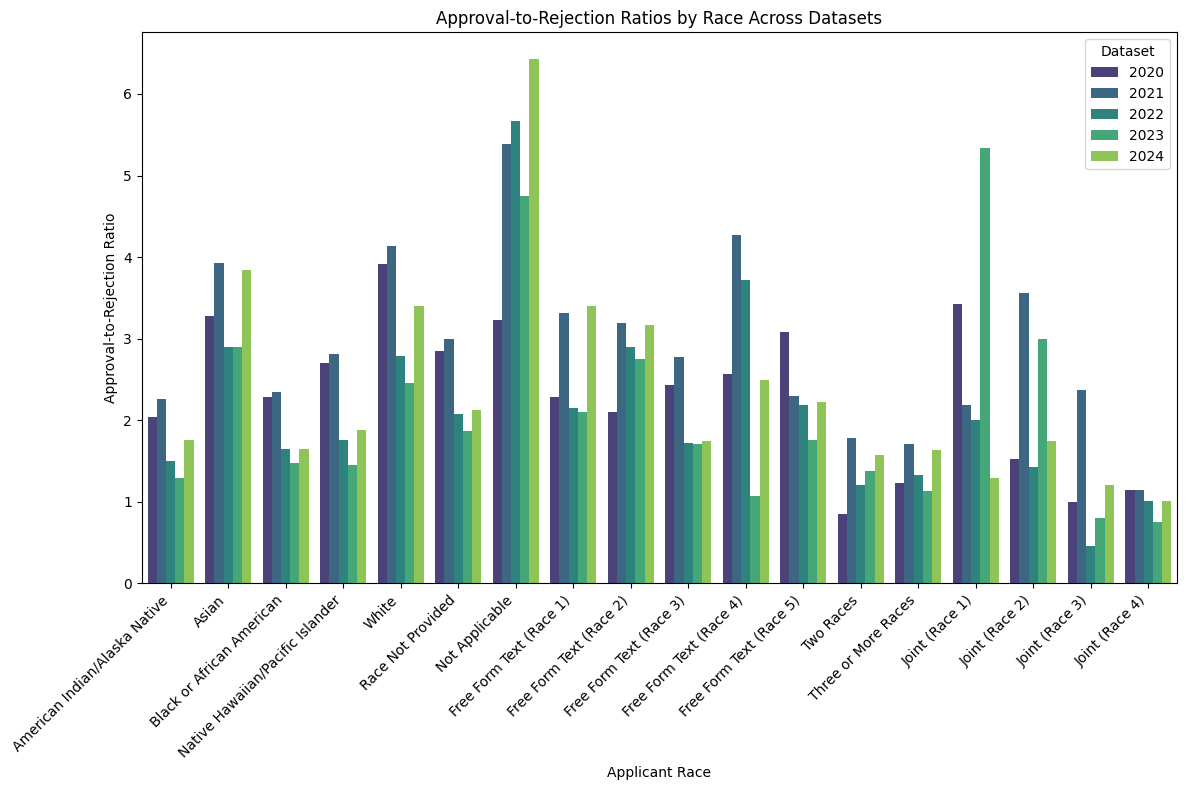

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_ratios,
    x='applicant_race-1',
    y='approval_to_rejection_ratio_race',
    hue='dataset',
    palette='viridis'
)
plt.title('Approval-to-Rejection Ratios by Race Across Datasets')
plt.xlabel('Applicant Race')
plt.ylabel('Approval-to-Rejection Ratio')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('AR_race.png', dpi=300)
plt.show()

## Institute Level

In [11]:
def approval_ratio_race_lei(df, dataset_name):
    approval_rejection_ratio = df.groupby(['applicant_race-1', 'lei']).apply(
        lambda x: x[x['action_taken'] == 1].shape[0] / max(1, x[x['action_taken'] == 3].shape[0])
    ).reset_index(name='approval_rejection_ratio')
    approval_rejection_ratio['dataset'] = dataset_name  # dataset identifier
    return approval_rejection_ratio


Next we get the ratios for all datasets

In [ ]:
ratios_df20 = approval_ratio_race_lei(df20, '2020')
ratios_df21 = approval_ratio_race_lei(df21, '2021')
ratios_df22 = approval_ratio_race_lei(df22, '2022')
ratios_df23 = approval_ratio_race_lei(df23, '2023')
ratios_df24 = approval_ratio_race_lei(df24, '2024')
combined_ratios = pd.concat([ratios_df20, ratios_df21, ratios_df22, ratios_df23, ratios_df24], ignore_index=True)
combined_ratios['applicant_race-1'] = combined_ratios['applicant_race-1'].map(race_mapping)

And plot them

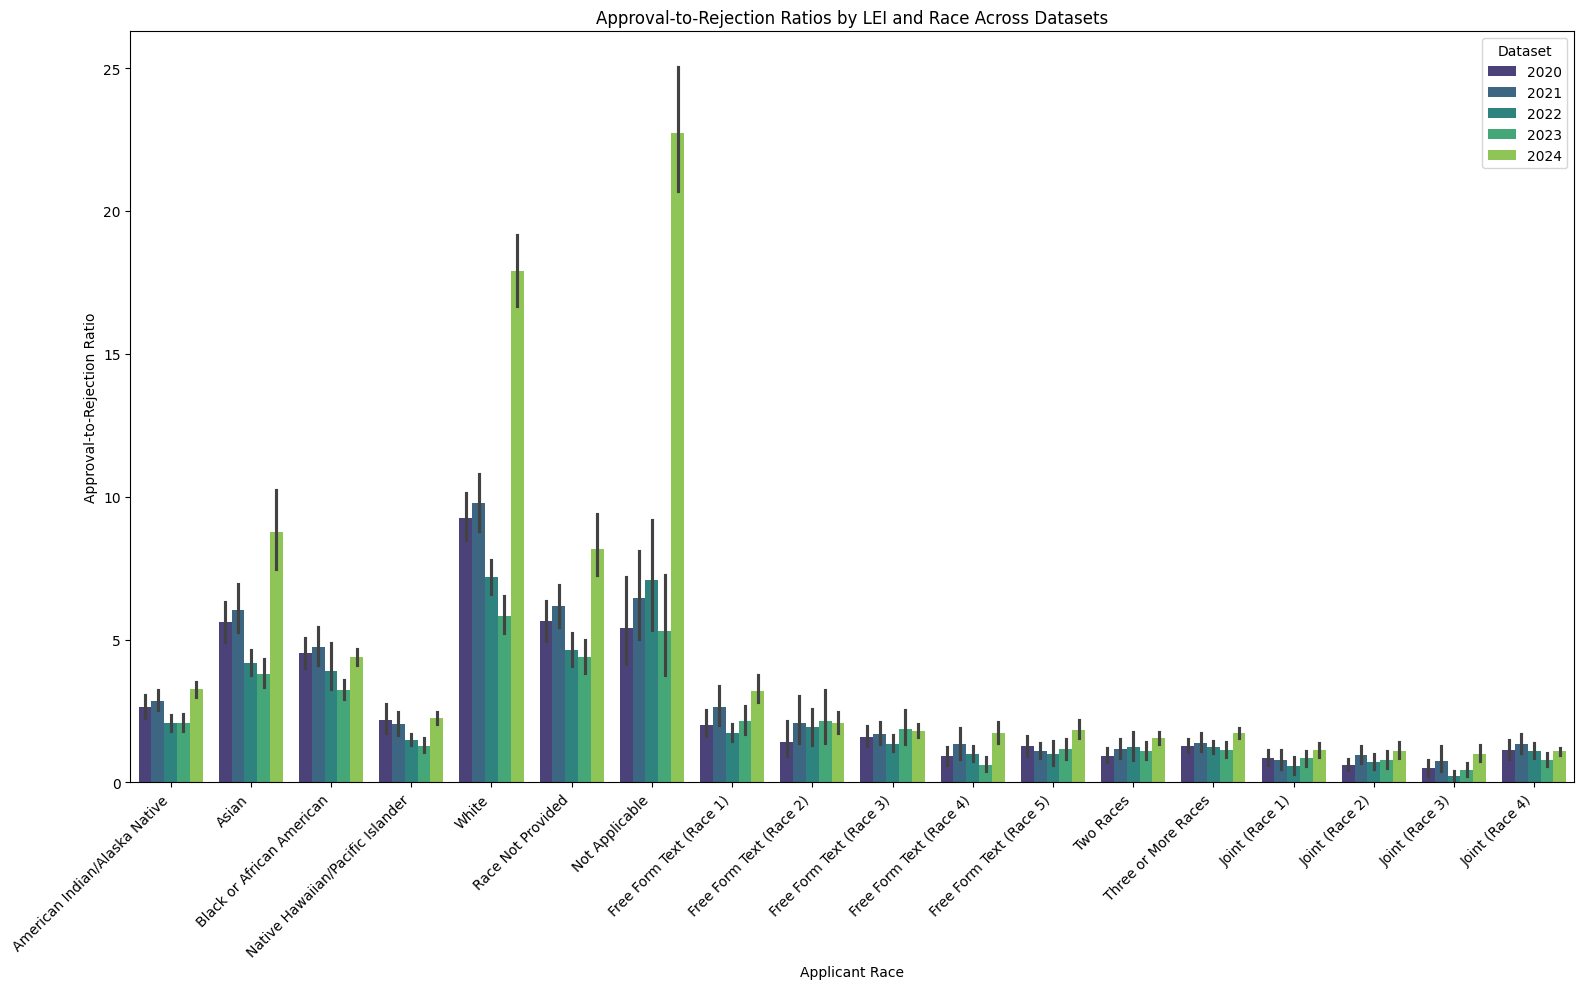

In [13]:
plt.figure(figsize=(16, 10))
sns.barplot(
    data=combined_ratios,
    x='applicant_race-1',
    y='approval_rejection_ratio',
    hue='dataset',
    palette='viridis')

plt.title('Approval-to-Rejection Ratios by LEI and Race Across Datasets')
plt.xlabel('Applicant Race')
plt.ylabel('Approval-to-Rejection Ratio')
plt.xticks(rotation=45, ha='right') 
plt.legend(title='Dataset')
plt.tight_layout()
plt.savefig('AR_lei2.png', dpi=300)
plt.show()

At institution level we have higher approval rate for white categories, which we didnt see at state level

## Data Cleaning 1

In [14]:
dfs = [df20, df21, df22, df23, df24]
dfs_dropped = [df.dropna(subset=['interest_rate', 'rate_spread']) for df in dfs]
df20_1, df21_1, df22_1, df23_1, df24_1 = dfs_dropped

In [15]:
datasets={'2020' : df20_1, '2021' : df21_1, '2022' : df22_1,
          '2023' : df23_1, '2024' : df24_1}

In [16]:
for year, df in datasets.items():
    datasets[year] = df[~df.apply(lambda row: row.astype(str).str.contains('Exempt').any(), axis=1)]
    
df20_1 = datasets['2020']
df21_1 = datasets['2021']
df22_1 = datasets['2022']
df23_1 = datasets['2023']
df24_1 = datasets['2024']

In [17]:
for name, df in datasets.items():
    print(f'Dataset :{name}')
    print(df['action_taken'].value_counts())
    print('-' * 40)

Dataset :2020
action_taken
1    865253
2     41237
8       269
Name: count, dtype: int64
----------------------------------------
Dataset :2021
action_taken
1    962873
2     46175
8       405
Name: count, dtype: int64
----------------------------------------
Dataset :2022
action_taken
1    589129
2     31573
8       346
Name: count, dtype: int64
----------------------------------------
Dataset :2023
action_taken
1    415564
2     21830
8      1038
Name: count, dtype: int64
----------------------------------------
Dataset :2024
action_taken
1    5407337
2     295320
8     101063
Name: count, dtype: int64
----------------------------------------


since we removed rows with missing interest rate and rate spread, only those approved or preapproved loans are left.

In [18]:
for name, df in datasets.items():
    print(f"Dataset: {name} → Unique LEIs: {df['lei'].nunique()}")

Dataset: 2020 → Unique LEIs: 1323
Dataset: 2021 → Unique LEIs: 1453
Dataset: 2022 → Unique LEIs: 1424
Dataset: 2023 → Unique LEIs: 1343
Dataset: 2024 → Unique LEIs: 2707


In [ ]:
for df in [df20_1, df21_1, df22_1, df23_1, df24_1]:
    df['interest_rate']= pd.to_numeric(df['interest_rate'], errors='coerce')
    df['rate_spread']= pd.to_numeric(df['rate_spread'], errors='coerce')

When looping over a list of DataFrames, direct modifications to columns (`df['col'] = ...`) will update the original DataFrames because they modify the internal structure of the existing objects. However, operations that replace the entire DataFrame (`df = df[...]`) create a new object and do not affect the original DataFrames in the list. To retain such replacements, you must either reassign the results back to variables or use a dictionary structure where you can update values by key.


In [20]:
for year, df in datasets.items():
    df_2 = df[(df['rate_spread'] > 0) & (df['rate_spread'] <= 10)]
    df_2 = df_2[(df_2['interest_rate'] >= 0) & (df_2['interest_rate'] <= 20)]
    datasets[year] = df_2

df20_2 = datasets['2020']
df21_2 = datasets['2021']
df22_2 = datasets['2022']
df23_2 = datasets['2023']
df24_2 = datasets['2024']


In [21]:
datasets = [df20_2, df21_2, df22_2, df23_2, df24_2]
years = ["2020", "2021", "2022", "2023", "2024"]

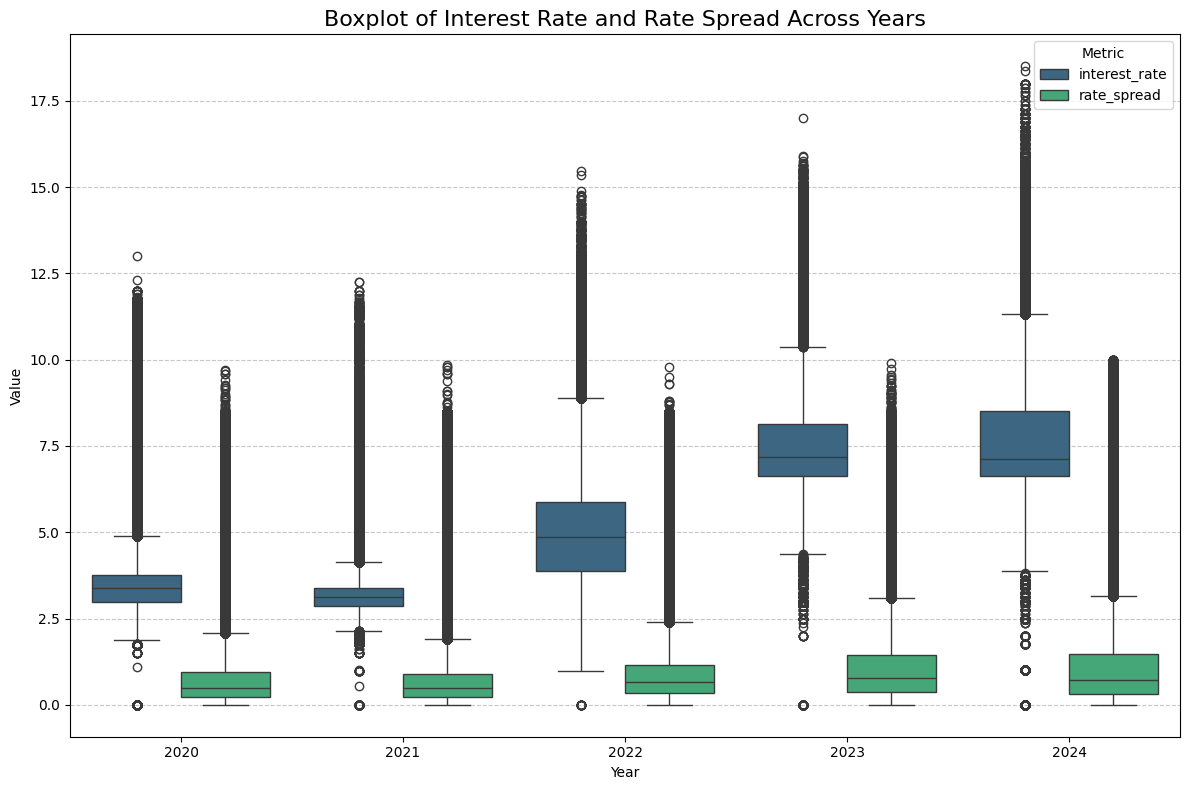

In [22]:
combined_data = pd.concat(datasets, keys=years, names=['Year', 'Index']).reset_index(level='Year')


melted_data = pd.melt(
    combined_data, 
    id_vars=['Year'], 
    value_vars=['interest_rate', 'rate_spread'], 
    var_name='Metric', 
    value_name='Value')


plt.figure(figsize=(12, 8))
sns.boxplot(data=melted_data, x='Year', y='Value', hue='Metric', palette='viridis')
plt.title('Boxplot of Interest Rate and Rate Spread Across Years', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('IR_RS_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
#pd.set_option('display.float_format', '{:.2f}'.format)

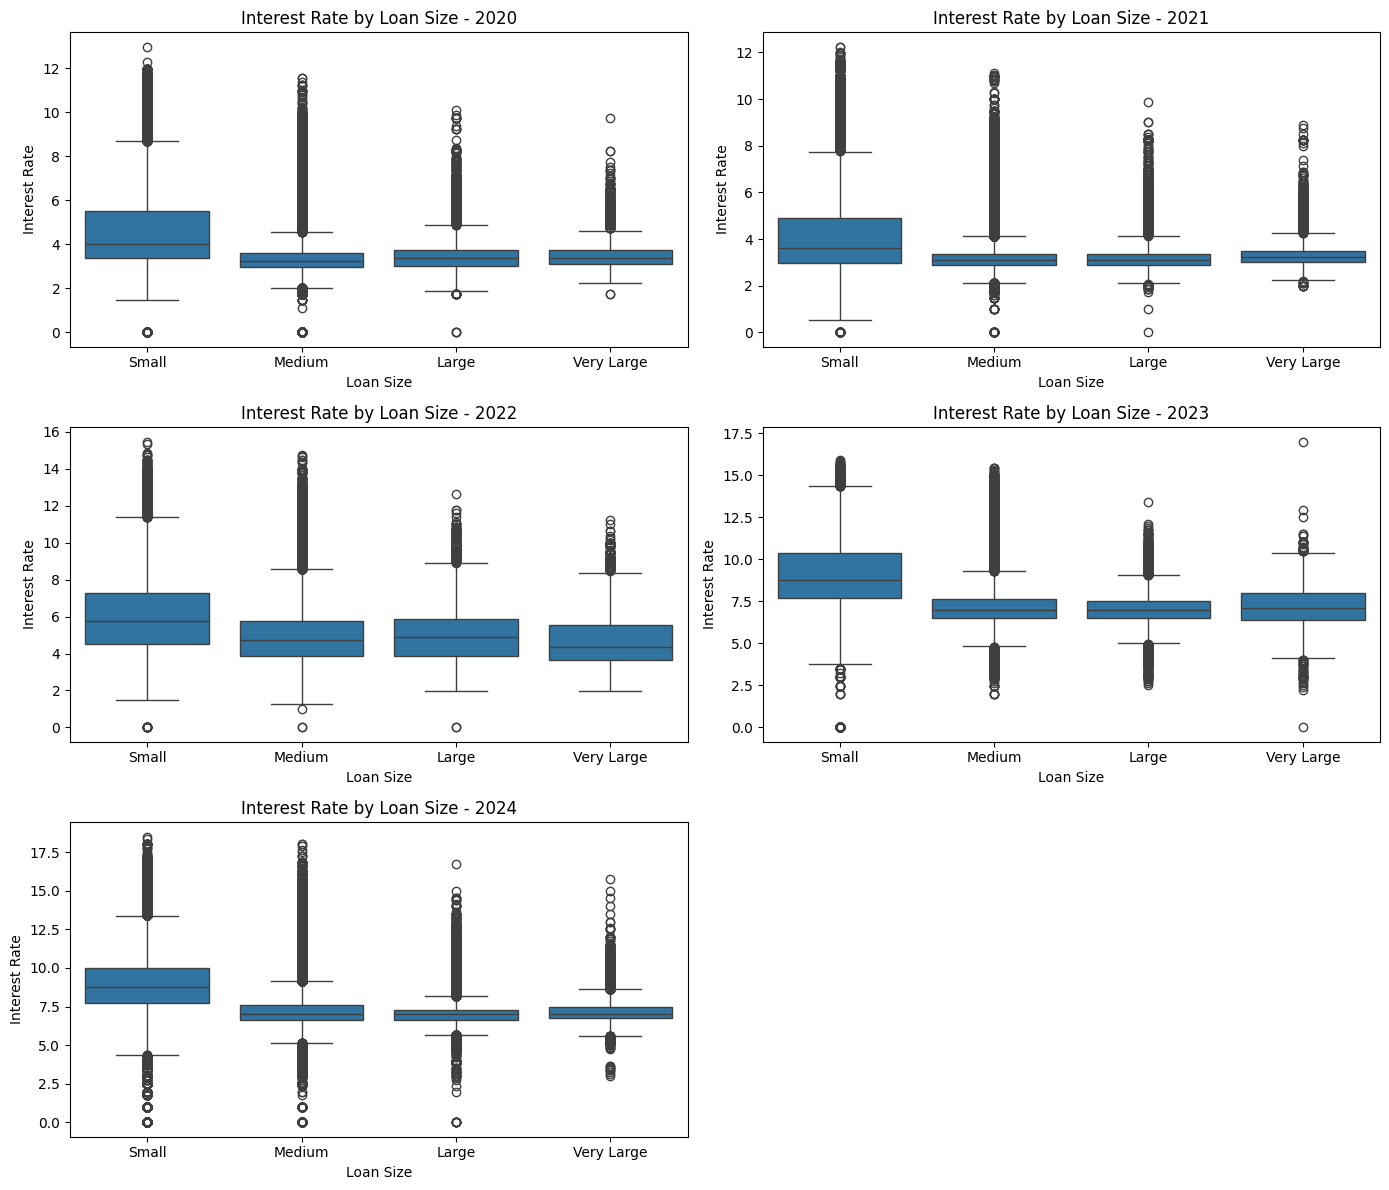

In [24]:
datasets = {
    '2020': df20_2,
    '2021': df21_2,
    '2022': df22_2,
    '2023': df23_2,
    '2024': df24_2}

bins = [0, 100000, 500000, 1000000, float('inf')]
labels = ['Small', 'Medium', 'Large', 'Very Large']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
axes = axes.flatten()

for i, (year, df) in enumerate(datasets.items()):
    df['loan_size'] = pd.cut(df['loan_amount'], bins=bins, labels=labels)
    sns.boxplot(x='loan_size', y='interest_rate', data=df, ax=axes[i])
    axes[i].set_title(f'Interest Rate by Loan Size - {year}')
    axes[i].set_xlabel('Loan Size')
    axes[i].set_ylabel('Interest Rate')

# remove unused subplot (6th plot spot)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## Data Cleaning 2 - Year 2024

**Note on Income Variable:**
Income is crucial for modeling loan decisions and fairness. While missing values could be imputed using features like `loan_amount`, `property_value`, and `tract_income`, with methods such as **expectation-maximization**, **KNN**, **regression imputation**, or **matrix factorization**, we chose to **drop rows with missing income and debt-to-income ratio** to ensure cleaner inferences and avoid introducing imputation bias.


In [25]:
df24_3 = df24_2.dropna(subset=['income', 'debt_to_income_ratio'])

Below I modify income (removing negative values and converting 0 incomes to 1. Multiplied the income by 1000 to be in same units as property value and loan amount)

In [26]:
df24_3 = df24_3[df24_3['income'] >= 0]
df24_3.loc[df24_3['income'] == 0, 'income'] = 1
income_cap = df24_3['income'].quantile(0.99)
df24_3 = df24_3[df24_3['income'] <= income_cap]
df24_3['income'] = df24_3['income'] * 1000

In [27]:
df24_3.shape

(3790231, 86)

There are a few number (<0.01%) of loans with loan amounts more than $5,000,000 making the distrubtion skewed, we can use log('loan_amount') or simply remove it. For now I removed them out of dataset, however we can later on keep them in the model and check their leverage using cooks distance or Hat matrix. 

In [28]:
loan_cap = df24_3['loan_amount'].quantile(0.99)
df24_3 = df24_3[df24_3['loan_amount'] <= loan_cap]
df24_3.shape

(3752493, 86)

the variable ['debt_to_income_ratio'] needs cleaning, it's a ration spanning from 10-99 % but we need to convert them into intigers.

In [29]:
def clean_debt_to_income_ratio(value):
    try:
        # missing values
        if pd.isnull(value):
            return np.nan
        elif isinstance(value, str):
            value = value.strip()  
            
            # 50%-60%
            if '-' in value and '%' in value:
                nums = [
                    float(num.strip('%').replace('<', '').replace('>', ''))
                    for num in value.split('-')
                    if num.strip('%').replace('<', '').replace('>', '').isnumeric()
                ]
                return np.mean(nums)
            
            # <30%
            elif value.startswith('<'):
                return float(value.strip('<%')) / 2  #midpoint below range
            
            # >60%
            elif value.startswith('>'):
                return float(value.strip('>%')) + 5  #slightly above range
            
            # "Exempt"
            elif value.lower() == 'exempt':
                return np.nan
            
            # numeric strings
            elif value.replace('.', '', 1).isdigit():
                return float(value)
            
        return value
    except ValueError as e:
        print(f"Error processing value: {value}. Error: {e}")
        return np.nan

In [30]:
df24_3['debt_to_income_ratio'] = df24_3['debt_to_income_ratio'].apply(clean_debt_to_income_ratio)
df24_3.shape

(3752493, 86)

In [31]:
age_mapping = {
    '35-44': 40, '45-54': 50, '55-64': 60, '25-34': 30,
    '65-74': 70, '>74': 75, '<25': 20, '8888': np.nan }


df24_3['applicant_age'] = df24_3['applicant_age'].map(age_mapping)

In [32]:
columns_to_extract = [
     'loan_type', 'loan_purpose', 'lei', #'census_tract', 
    'rate_spread', 'applicant_age', 'loan_term', 'property_value', 'loan_amount',
    'interest_rate', 'action_taken', 'income', 'debt_to_income_ratio']

df24_4 = df24_3[columns_to_extract]

In [33]:
df24_4 = df24_4[~df24_4.apply(lambda row: row.astype(str).str.contains('Exempt').any(), axis=1)]

In [34]:
df24_4 = df24_4.dropna() 
df24_4.shape

(3730302, 12)

In [35]:
df24_4 = df24_4[~df24_4.apply(
    lambda row: row.astype(str).str.strip().str.lower().isin(['na', 'nan', 'missing', '']).any(),
    axis=1
)]
df24_4.shape

(3730302, 12)

In [36]:
df24_4['loan_type'] = df24_4['loan_type'].astype('category')
df24_4['loan_purpose'] = df24_4['loan_purpose'].astype('category')
df24_4['action_taken'] = df24_4['action_taken'].astype('category')
df24_4['loan_term'] = df24_4['loan_term'].astype('float')
df24_4['property_value'] = df24_4['property_value'].astype('float')


There are 59574 of loan terms less than 100, with 55000 of them are originated loans, I also removed <50 out of dataset

In [37]:
(df24_4['loan_term'].astype(float) < 100).sum()

59252

In [38]:
df24_4[df24_4['loan_term'].astype(float) < 100]['action_taken'].value_counts()

action_taken
1    55298
2     3932
8       22
Name: count, dtype: int64

In [39]:
df24_4 = df24_4[~(df24_4['loan_term'].astype(float) < 50)]
df24_4.shape

(3722072, 12)

## Feature Engineering

In [40]:
df24_4['down_payment'] = df24_4['property_value'] - df24_4['loan_amount']

$\text{Monthly Payment} = \frac{\text{Loan Amount}}{\text{Loan Term (Months)}}$

In [41]:
df24_4['monthly_payment'] = df24_4['loan_amount'] / df24_4['loan_term']

$\text{Down Payment Ratio} = \frac{\text{Down Payment}}{\text{Propert Value}}$\
\
Shows how much of the property's cost is paid upfront

In [42]:
df24_4['down_payment_ratio'] = df24_4['down_payment'] / df24_4['property_value']

$\text{Affordability Ratio (AFR)} = \frac{\text{Monthly Payment}}{\text{Income (Monthly)}}$

In [43]:
df24_4['affordability_ratio'] = (df24_4['income'] / 12) / df24_4['monthly_payment']

**loan-to-value (LTV) ratio** reflects **risk**:

* **0**: likely data error — implies \$0 loan or infinite property value.
* **< 50%**: very low risk — borrower pays most upfront.
* **70–80%**: common for conventional loans — moderate risk.
* **> 95%**: high risk — borrower puts little down, more likely to default.
* **99+%**: extreme risk or data issue — nearly no equity in the property.

Lenders prefer **lower LTVs** — they indicate more borrower commitment and lower potential loss.


In [44]:
#this column is missing in 2024 dataset so we create them using:
df24_4['loan_to_value_ratio'] = df24_4['loan_amount'] / df24_4['property_value']

**debt-to-income ratio (DTI)** shows how much of a borrower’s income goes toward debt payments:

* **< 20%**: low risk
* **20–36%**: acceptable
* **> 43%**: risky (may fail mortgage approval)
* **> 50%**: high default risk

Higher DTI → less ability to handle new debt → more risk.


$\text{Risk Factor} = \text{Debt-to-Income Ratio (DTI)} \times \text{Loan-to-Value Ratio (LTV)}
$

In [45]:
df24_4['risk_factor'] = df24_4['debt_to_income_ratio'] * df24_4['loan_to_value_ratio']


$$
\text{Normalized Risk Factor} = \frac{\text{Risk Factor} - \min(\text{Risk Factor})}{\max(\text{Risk Factor}) - \min(\text{Risk Factor})}
$$


In [46]:
df24_4['normalized_risk_factor'] = (
    (df24_4['risk_factor'] - df24_4['risk_factor'].min()) /
    (df24_4['risk_factor'].max() - df24_4['risk_factor'].min()))

We can take look at applicants with 0 or 9900 % (two extremes)  LTV

In [47]:
df24_4['ltv_category'] = pd.cut(df24_4['loan_to_value_ratio'], 
                                bins=[-0.01, 0.01, 0.5, 0.8, 0.95, 1.5, np.inf], 
                                labels=['0', 'Low', 'Medium', 'High', 'Very High', 'Extreme'])
df24_4['ltv_category'] = pd.Categorical(
    df24_4['ltv_category'],
    categories=['0', 'Low', 'Medium', 'High', 'Very High', 'Extreme'],
    ordered=True
)

In [48]:
pd.concat([
    df24_4.nsmallest(5, 'loan_to_value_ratio'),
    df24_4.nlargest(5, 'loan_to_value_ratio')
])


,loan_type,loan_purpose,lei,rate_spread,applicant_age,loan_term,property_value,loan_amount,interest_rate,action_taken,income,debt_to_income_ratio,down_payment,monthly_payment,down_payment_ratio,affordability_ratio,loan_to_value_ratio,risk_factor,normalized_risk_factor,ltv_category
1788874,1,1,5493007ASPHNTEYEZ797,0.715,50.0,120.0,2.147484e+09,15000,6.375,1,98000.0,39.0,2.147469e+09,125.000000,0.999993,65.333333,0.000007,0.000272,0.000000,0
2357885,1,2,54930082CRK7E43ZJ680,1.920,70.0,180.0,4.100050e+08,65000,7.250,1,36000.0,39.0,4.099400e+08,361.111111,0.999841,8.307692,0.000159,0.006183,0.000002,0
4806842,1,32,549300HC2W2SFF3LU356,0.574,50.0,240.0,1.737950e+08,55000,7.365,1,19000.0,45.0,1.737400e+08,229.166667,0.999684,6.909091,0.000316,0.014241,0.000006,0
9518501,1,2,5493001GCBD5XGNIC815,4.560,50.0,180.0,1.224500e+07,5000,12.740,2,90000.0,55.0,1.224000e+07,27.777778,0.999592,270.000000,0.000408,0.022458,0.000009,0
8525809,1,32,549300043MOZCJ4RK371,0.470,50.0,120.0,2.500050e+08,145000,6.990,1,175000.0,33.0,2.498600e+08,1208.333333,0.999420,12.068966,0.000580,0.019140,0.000008,0
683646,1,1,5493003EAJYUK1F8B139,0.279,30.0,360.0,5.000000e+03,495000,6.250,1,239000.0,25.0,-4.900000e+05,1375.000000,-98.000000,14.484848,99.000000,2475.000000,1.000000,Extreme
12174028,1,31,549300AQ3T62GXDU7D76,0.144,40.0,360.0,5.000000e+03,325000,6.875,2,166000.0,25.0,-3.200000e+05,902.777778,-64.000000,15.323077,65.000000,1625.000000,0.656566,Extreme
12102420,1,32,549300AQ3T62GXDU7D76,0.022,40.0,180.0,5.000000e+03,305000,6.250,2,187000.0,37.0,-3.000000e+05,1694.444444,-60.000000,9.196721,61.000000,2257.000000,0.911919,Extreme
1800595,1,32,549300OS8C7J7ZWMNL70,0.650,60.0,300.0,5.000000e+03,255000,8.750,1,229000.0,25.0,-2.500000e+05,850.000000,-50.000000,22.450980,51.000000,1275.000000,0.515151,Extreme
12198247,1,32,549300AQ3T62GXDU7D76,1.319,75.0,360.0,5.000000e+03,255000,7.500,2,165000.0,25.0,-2.500000e+05,708.333333,-50.000000,19.411765,51.000000,1275.000000,0.515151,Extreme


The rows with very high LTV ratios and negative down payments likely indicate risky loans where the borrower owes more than the property’s value—possibly due to cash-out refinancing, special loan structures, or data errors. A negative down payment means the loan amount exceeded the property value, making these applicants extremely high-risk and suggesting either financial stress or incorrect data entries.
where loan pupose codes are\
\
loan_purpose_map = {\
    1: "Home purchase",\
    2: "Home improvement",\
    4: "Refinancing",\
    5: "Cash-out refinancing",\
    31: "Other purpose",\
    32: "Not applicable"\
}


### This plot needs more data cleaning, data is very imbalanced 3,500,000 originated loans vs ~300,000 (pre)approved loans but not accepted by consumers

In [49]:
df24_4['action_taken'].value_counts()

action_taken
1    3449415
2     203230
8      69427
Name: count, dtype: int64

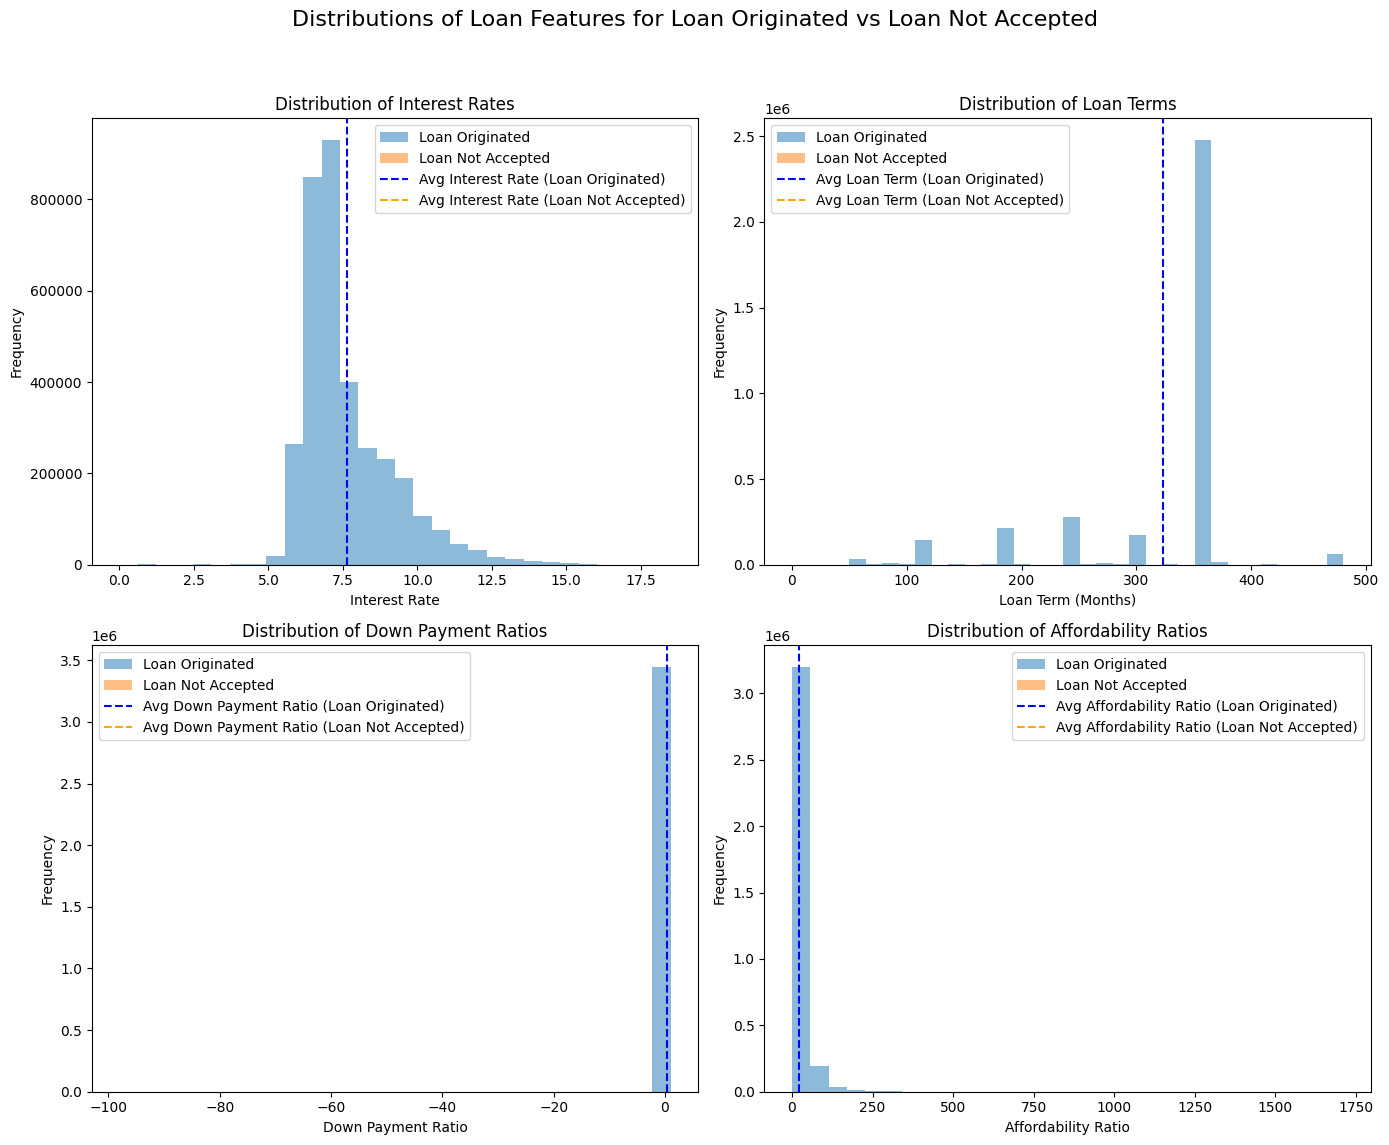

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 12))


axs[0, 0].hist(df24_4[df24_4['action_taken'] == 1]['interest_rate'], bins=30, alpha=0.5, label="Loan Originated")
axs[0, 0].hist(df24_4[df24_4['action_taken'] == 0]['interest_rate'], bins=30, alpha=0.5, label="Loan Not Accepted")
axs[0, 0].axvline(df24_4[df24_4['action_taken'] == 1]['interest_rate'].mean(), color='blue', linestyle='--', label="Avg Interest Rate (Loan Originated)")
axs[0, 0].axvline(df24_4[df24_4['action_taken'] == 0]['interest_rate'].mean(), color='orange', linestyle='--', label="Avg Interest Rate (Loan Not Accepted)")
axs[0, 0].set_title("Distribution of Interest Rates")
axs[0, 0].set_xlabel("Interest Rate")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].legend()


axs[0, 1].hist(df24_4[df24_4['action_taken'] == 1]['loan_term'], bins=30, alpha=0.5, label="Loan Originated")
axs[0, 1].hist(df24_4[df24_4['action_taken'] == 0]['loan_term'], bins=30, alpha=0.5, label="Loan Not Accepted")
axs[0, 1].axvline(df24_4[df24_4['action_taken'] == 1]['loan_term'].mean(), color='blue', linestyle='--', label="Avg Loan Term (Loan Originated)")
axs[0, 1].axvline(df24_4[df24_4['action_taken'] == 0]['loan_term'].mean(), color='orange', linestyle='--', label="Avg Loan Term (Loan Not Accepted)")
axs[0, 1].set_title("Distribution of Loan Terms")
axs[0, 1].set_xlabel("Loan Term (Months)")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].legend()


axs[1, 0].hist(df24_4[df24_4['action_taken'] == 1]['down_payment_ratio'], bins=30, alpha=0.5, label="Loan Originated")
axs[1, 0].hist(df24_4[df24_4['action_taken'] == 0]['down_payment_ratio'], bins=30, alpha=0.5, label="Loan Not Accepted")
axs[1, 0].axvline(df24_4[df24_4['action_taken'] == 1]['down_payment_ratio'].mean(), color='blue', linestyle='--', label="Avg Down Payment Ratio (Loan Originated)")
axs[1, 0].axvline(df24_4[df24_4['action_taken'] == 0]['down_payment_ratio'].mean(), color='orange', linestyle='--', label="Avg Down Payment Ratio (Loan Not Accepted)")
axs[1, 0].set_title("Distribution of Down Payment Ratios")
axs[1, 0].set_xlabel("Down Payment Ratio")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].legend()


axs[1, 1].hist(df24_4[df24_4['action_taken'] == 1]['affordability_ratio'], bins=30, alpha=0.5, label="Loan Originated")
axs[1, 1].hist(df24_4[df24_4['action_taken'] == 0]['affordability_ratio'], bins=30, alpha=0.5, label="Loan Not Accepted")
axs[1, 1].axvline(df24_4[df24_4['action_taken'] == 1]['affordability_ratio'].mean(), color='blue', linestyle='--', label="Avg Affordability Ratio (Loan Originated)")
axs[1, 1].axvline(df24_4[df24_4['action_taken'] == 0]['affordability_ratio'].mean(), color='orange', linestyle='--', label="Avg Affordability Ratio (Loan Not Accepted)")
axs[1, 1].set_title("Distribution of Affordability Ratios")
axs[1, 1].set_xlabel("Affordability Ratio")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].legend()

fig.suptitle("Distributions of Loan Features for Loan Originated vs Loan Not Accepted", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('combined_distributions.png', dpi=300)
plt.show()


## back to original dataset before cleaning
for this analysis we need to have thee information of denied cases, therefore we use the data we originally created with zero cleaning, as we only will work with number of applicants in each 1, 2, 3 categories of 'action_taken', and the institution lei

In [51]:
institution_data = df24.groupby('lei').agg(
    total_applicants=('action_taken', 'count'),
    borrower_accepted_loans=('action_taken', lambda x: (x == 1).sum()),  # 1 = Borrower accepted
    borrower_declined_loans=('action_taken', lambda x: (x == 2).sum()),  # 2 = Borrower declined
    rejected_loans=('action_taken', lambda x: (x == 3).sum())  # 3 = Denied
).reset_index()


Total number of financial institutions in 2024 dataset:

In [52]:
institution_data.shape

(4908, 5)

In [53]:
institution_data['approved_loans'] = (
    institution_data['borrower_accepted_loans'] + institution_data['borrower_declined_loans'])

institution_data['approval_rate'] = institution_data['approved_loans'] / (
    institution_data['approved_loans'] + institution_data['rejected_loans'])


institution_data['borrower_decline_rate'] = (
    institution_data['borrower_declined_loans'] / institution_data['approved_loans'])


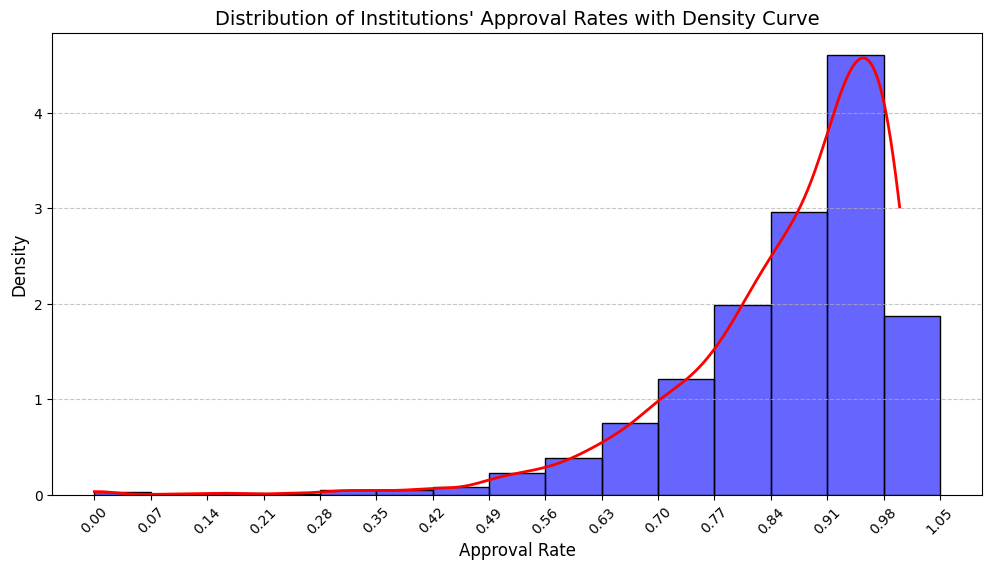

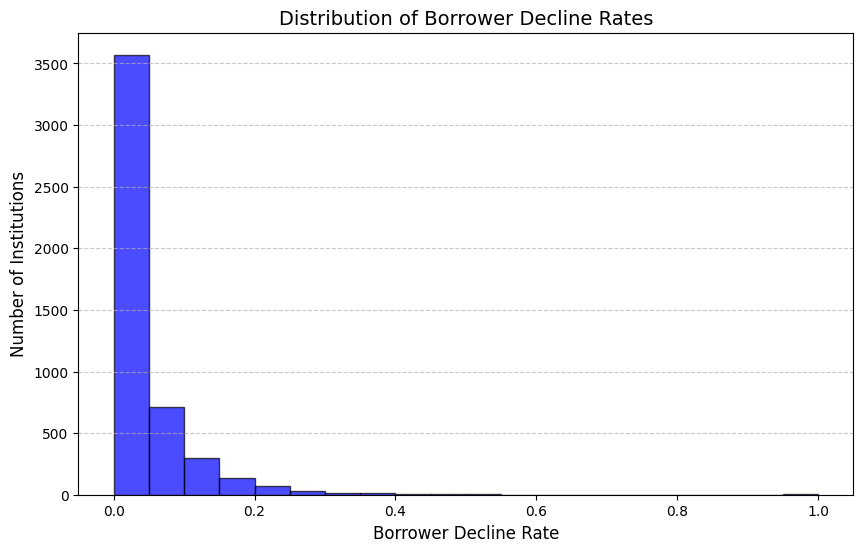

In [54]:
bins = np.arange(0, 1.12, 0.07)
labels = [f"({round(bins[i], 2)}-{round(bins[i+1], 2)}]" for i in range(len(bins)-1)]

# Histogram + KDE for approval rate
plt.figure(figsize=(12, 6))
data = institution_data["approval_rate"].dropna()

sns.histplot(data, bins=bins, kde=False, edgecolor='black', alpha=0.6, color='blue', stat="density", label="Histogram")
kde = gaussian_kde(data)
x_range = np.linspace(min(data), max(data), 1000)
plt.plot(x_range, kde(x_range), color='red', linewidth=2, label="Density Curve")

plt.title("Distribution of Institutions' Approval Rates with Density Curve", fontsize=14)
plt.xlabel("Approval Rate", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xticks(bins, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Histogram for borrower decline rate
plt.figure(figsize=(10, 6))
plt.hist(institution_data["borrower_decline_rate"].dropna(), bins=20, edgecolor='black', alpha=0.7, color='blue')
plt.title("Distribution of Borrower Decline Rates", fontsize=14)
plt.xlabel("Borrower Decline Rate", fontsize=12)
plt.ylabel("Number of Institutions", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

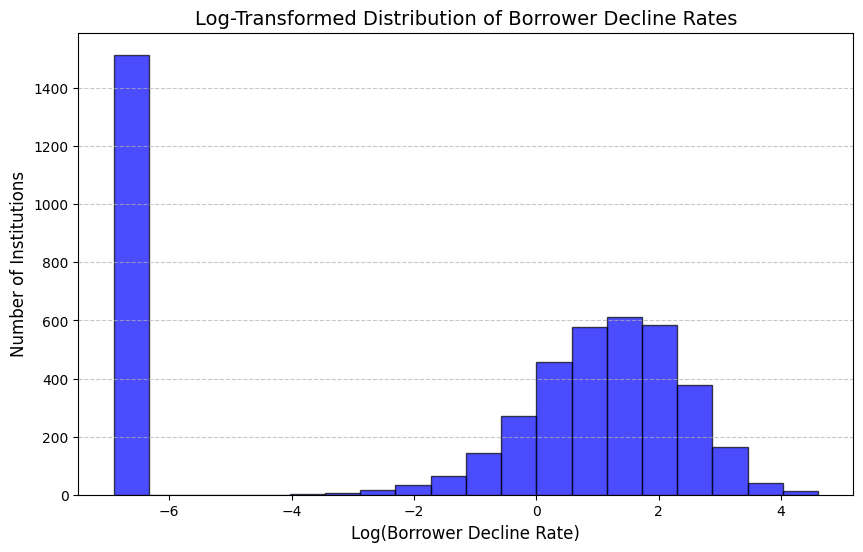

In [55]:
# Apply log transformation to borrower decline rate
epsilon = 0.001
institution_data["log_borrower_decline_rate"] = np.log((institution_data["borrower_decline_rate"] * 100) + epsilon)

# Plot histogram of log-transformed borrower decline rate
plt.figure(figsize=(10, 6))
plt.hist(institution_data["log_borrower_decline_rate"].dropna(), bins=20, edgecolor='black', alpha=0.7, color='blue')

plt.title("Log-Transformed Distribution of Borrower Decline Rates", fontsize=14)
plt.xlabel("Log(Borrower Decline Rate)", fontsize=12)
plt.ylabel("Number of Institutions", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [56]:
above_85 = (institution_data['approval_rate'] > 0.85).sum()
between_60_85 = ((institution_data['approval_rate'] > 0.60) & (institution_data['approval_rate'] <= 0.85)).sum()
total_institutions = institution_data.shape[0]


percent_above_85 = round((above_85 / total_institutions) * 100, 2)
print(percent_above_85, "% of institutions approve 85% and more of total loan applications")
percent_between_60_85 = round((between_60_85 / total_institutions) * 100, 2)
print(percent_between_60_85, "% of institutions approve 60_85% of total loan applications")

63.63 % of institutions approve 85% and more of total loan applications
31.36 % of institutions approve 60_85% of total loan applications


In [57]:
num_above_25 = (institution_data['borrower_decline_rate'] > 0.25).sum()
total_institutions = institution_data.shape[0]
percent_above_25 = round((num_above_25 / total_institutions) * 100, 2)
print(percent_above_25,"% or ",num_above_25, " of institutions out of 4908 total institutions have lost 25% and more of their clients due to their non-attractive products")

1.73 % or  85  of institutions out of 4908 total institutions have lost 25% and more of their clients due to their non-attractive products


Out of 4,908 institutions, 63.63% approved more than 85% of loan applications, indicating a generally high approval trend, while 31.36% approved between 60–85%, showing moderate selectiveness. However, only 1.73% (85 institutions) experienced over 25% borrower decline rates, suggesting that very few lenders are consistently losing clients—likely due to uncompetitive or unattractive loan offers.


# Modeling

In [58]:
df24_4['action_taken'] = df24_4['action_taken'].apply(lambda x: 1 if x == 1 else (0 if x in [2, 8] else np.nan))
df_model = df24_4[df24_4['action_taken'].notna()].copy()

In [59]:
df_model['action_taken'].value_counts() # need to be balanced


action_taken
1    3449415
0     272657
Name: count, dtype: int64

In [60]:
accepted = df_model[df_model['action_taken'] == 1]
declined = df_model[df_model['action_taken'] == 0]

accepted_sample = accepted.sample(n=len(declined), random_state=42)
df_model = pd.concat([accepted_sample, declined], axis=0).sample(frac=1, random_state=42).reset_index(drop=True)

In [61]:
df_model['original_index'] = df_model.index
df_model = df_model.reset_index(drop=True)

X = df_model.drop(columns=[
    'lei', 'interest_rate', 'action_taken'])

y = df_model['interest_rate']
X['log_income'] = np.log1p(df_model['income'])
X['log_loan_amount'] = np.log1p(df_model['loan_amount'])
X = X.drop(columns=['income', 'loan_amount'])

categorical_columns = ['loan_type', 'loan_purpose', 'ltv_category']
X = pd.get_dummies(X, columns=categorical_columns, drop_first=True)


In [62]:
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(
    X, y, df_model.index, test_size=0.2, random_state=42)

#X_train = X_train.reset_index(drop=True)
#X_test = X_test.reset_index(drop=True)


In [63]:
#X_train['original_index'] = df_model.loc[train_idx, 'original_index'].values
#X_test['original_index'] = df_model.loc[test_idx, 'original_index'].values

In [64]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.drop(columns=['original_index']))
X_test_scaled = scaler.transform(X_test.drop(columns=['original_index']))

y_train = np.array(y_train)
y_test = np.array(y_test)

In [65]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
val_losses = []
best_model = None
best_val_loss = float('inf')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
input_shape = X_train_scaled.shape[1]

for fold_idx, (train_fold_idx, val_fold_idx) in enumerate(kfold.split(X_train_scaled)):
    print(f"Fold {fold_idx + 1}")
    X_train_fold, X_val_fold = X_train_scaled[train_fold_idx], X_train_scaled[val_fold_idx]
    y_train_fold, y_val_fold = y_train[train_fold_idx], y_train[val_fold_idx]

    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train_fold, y_train_fold, epochs=1000, batch_size=32,
                        validation_data=(X_val_fold, y_val_fold),
                        callbacks=[early_stopping], verbose=0)
    print(f"Epochs run for Fold {fold_idx + 1}: {len(history.history['loss'])}")

    val_loss = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(val_loss)
    print(f"Validation Loss for Fold {fold_idx + 1}: {val_loss}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

print(f"Mean validation loss: {np.mean(val_losses)}")


Fold 1
Epochs run for Fold 1: 39
Validation Loss for Fold 1: 0.36990976333618164
Fold 2
Epochs run for Fold 2: 38
Validation Loss for Fold 2: 0.3796059787273407
Fold 3
Epochs run for Fold 3: 61
Validation Loss for Fold 3: 0.3634644150733948
Fold 4
Epochs run for Fold 4: 50
Validation Loss for Fold 4: 0.3606976866722107
Fold 5
Epochs run for Fold 5: 22
Validation Loss for Fold 5: 0.3828969895839691
Mean validation loss: 0.3713149666786194


In [66]:
best_predicted_interest_rates = best_model.predict(X_test_scaled).flatten()
actual_interest_rates = df_model.loc[test_idx, 'interest_rate'].values


3409/3409 [==============================] - 1s 229us/step


In [67]:
df_interest_rate_comparison = pd.DataFrame({
    'original_index': X_test['original_index'].values,
    'actual_interest_rate': actual_interest_rates,
    'predicted_interest_rate': best_predicted_interest_rates})

In [68]:
absolute_errors = np.abs(actual_interest_rates - best_predicted_interest_rates)
top_20_best_indices = np.argsort(absolute_errors)[:20]
top_20_best_original_indices = X_test.iloc[top_20_best_indices]['original_index'].values

df_top_20_best_predictions = df_model.loc[top_20_best_original_indices].copy()
df_top_20_best_predictions['predicted_interest_rate'] = df_interest_rate_comparison.set_index('original_index').loc[top_20_best_original_indices]['predicted_interest_rate'].values

#df_top_20_best_predictions.to_csv("top_20_best_predictions.csv", index=False)


In [69]:
pd.set_option('display.max_columns', None)
df_top_20_best_predictions

,loan_type,loan_purpose,lei,rate_spread,applicant_age,loan_term,property_value,loan_amount,interest_rate,action_taken,income,debt_to_income_ratio,down_payment,monthly_payment,down_payment_ratio,affordability_ratio,loan_to_value_ratio,risk_factor,normalized_risk_factor,ltv_category,original_index,predicted_interest_rate
216378,1,1,5493000YNV8IX4VD3X12,2.370,60.0,300.0,235000.0,225000,8.800,1,199000.0,38.0,10000.0,750.000000,0.042553,22.111111,0.957447,36.382979,0.014700,Very High,216378,8.799994
18104,2,1,549300VZVN841I2ILS84,0.309,60.0,360.0,185000.0,145000,6.188,1,56000.0,55.0,40000.0,402.777778,0.216216,11.586207,0.783784,43.108108,0.017417,Medium,18104,6.187990
451491,3,1,5493005PKOSG7MYX0B34,0.075,30.0,360.0,175000.0,175000,6.490,0,47000.0,55.0,0.0,486.111111,0.000000,8.057143,1.000000,55.000000,0.022222,Very High,451491,6.489979
321090,1,32,54930063XGNMIXS57091,0.558,40.0,180.0,185000.0,45000,6.990,1,75000.0,37.0,140000.0,250.000000,0.756757,25.000000,0.243243,9.000000,0.003636,Low,321090,6.990023
46571,3,32,549300VORTI31GZTJL53,0.956,40.0,360.0,1255000.0,425000,7.250,0,451000.0,10.0,830000.0,1180.555556,0.661355,31.835294,0.338645,3.386454,0.001368,Low,46571,7.249977
58374,1,32,549300LBCBNR1OT00651,0.228,70.0,360.0,625000.0,315000,6.625,1,79000.0,36.0,310000.0,875.000000,0.496000,7.523810,0.504000,18.144000,0.007331,Medium,58374,6.624969
453052,1,1,549300FS35FQXZRU4Z45,0.446,40.0,360.0,215000.0,185000,6.750,0,110000.0,49.0,30000.0,513.888889,0.139535,17.837838,0.860465,42.162791,0.017035,High,453052,6.749969
130599,1,1,254900E6AIE4Z8YQM970,4.632,30.0,360.0,495000.0,395000,10.750,0,266000.0,33.0,100000.0,1097.222222,0.202020,20.202532,0.797980,26.333333,0.010640,Medium,130599,10.749966
325577,2,1,549300GSCUJKJINRJ980,0.486,40.0,360.0,265000.0,255000,6.250,1,55000.0,46.0,10000.0,708.333333,0.037736,6.470588,0.962264,44.264151,0.017884,Very High,325577,6.249965
279050,2,32,8I3UVGYULPJQIP7FQV10,0.222,50.0,360.0,175000.0,145000,6.250,1,152000.0,41.0,30000.0,402.777778,0.171429,31.448276,0.828571,33.971429,0.013726,High,279050,6.249963


In [70]:
if best_model is not None:
    predicted_interest_rate = best_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, predicted_interest_rate)
    mse = mean_squared_error(y_test, predicted_interest_rate)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predicted_interest_rate)

    print(f"Test Loss (Best Model): {best_model.evaluate(X_test_scaled, y_test, verbose=0)}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R²: {r2}")


3409/3409 [==============================] - 1s 215us/step
Test Loss (Best Model): 0.3728697896003723
MAE: 0.4043527723637857
MSE: 0.37286917336958936
RMSE: 0.6106301444979517
R²: 0.8956188153698467


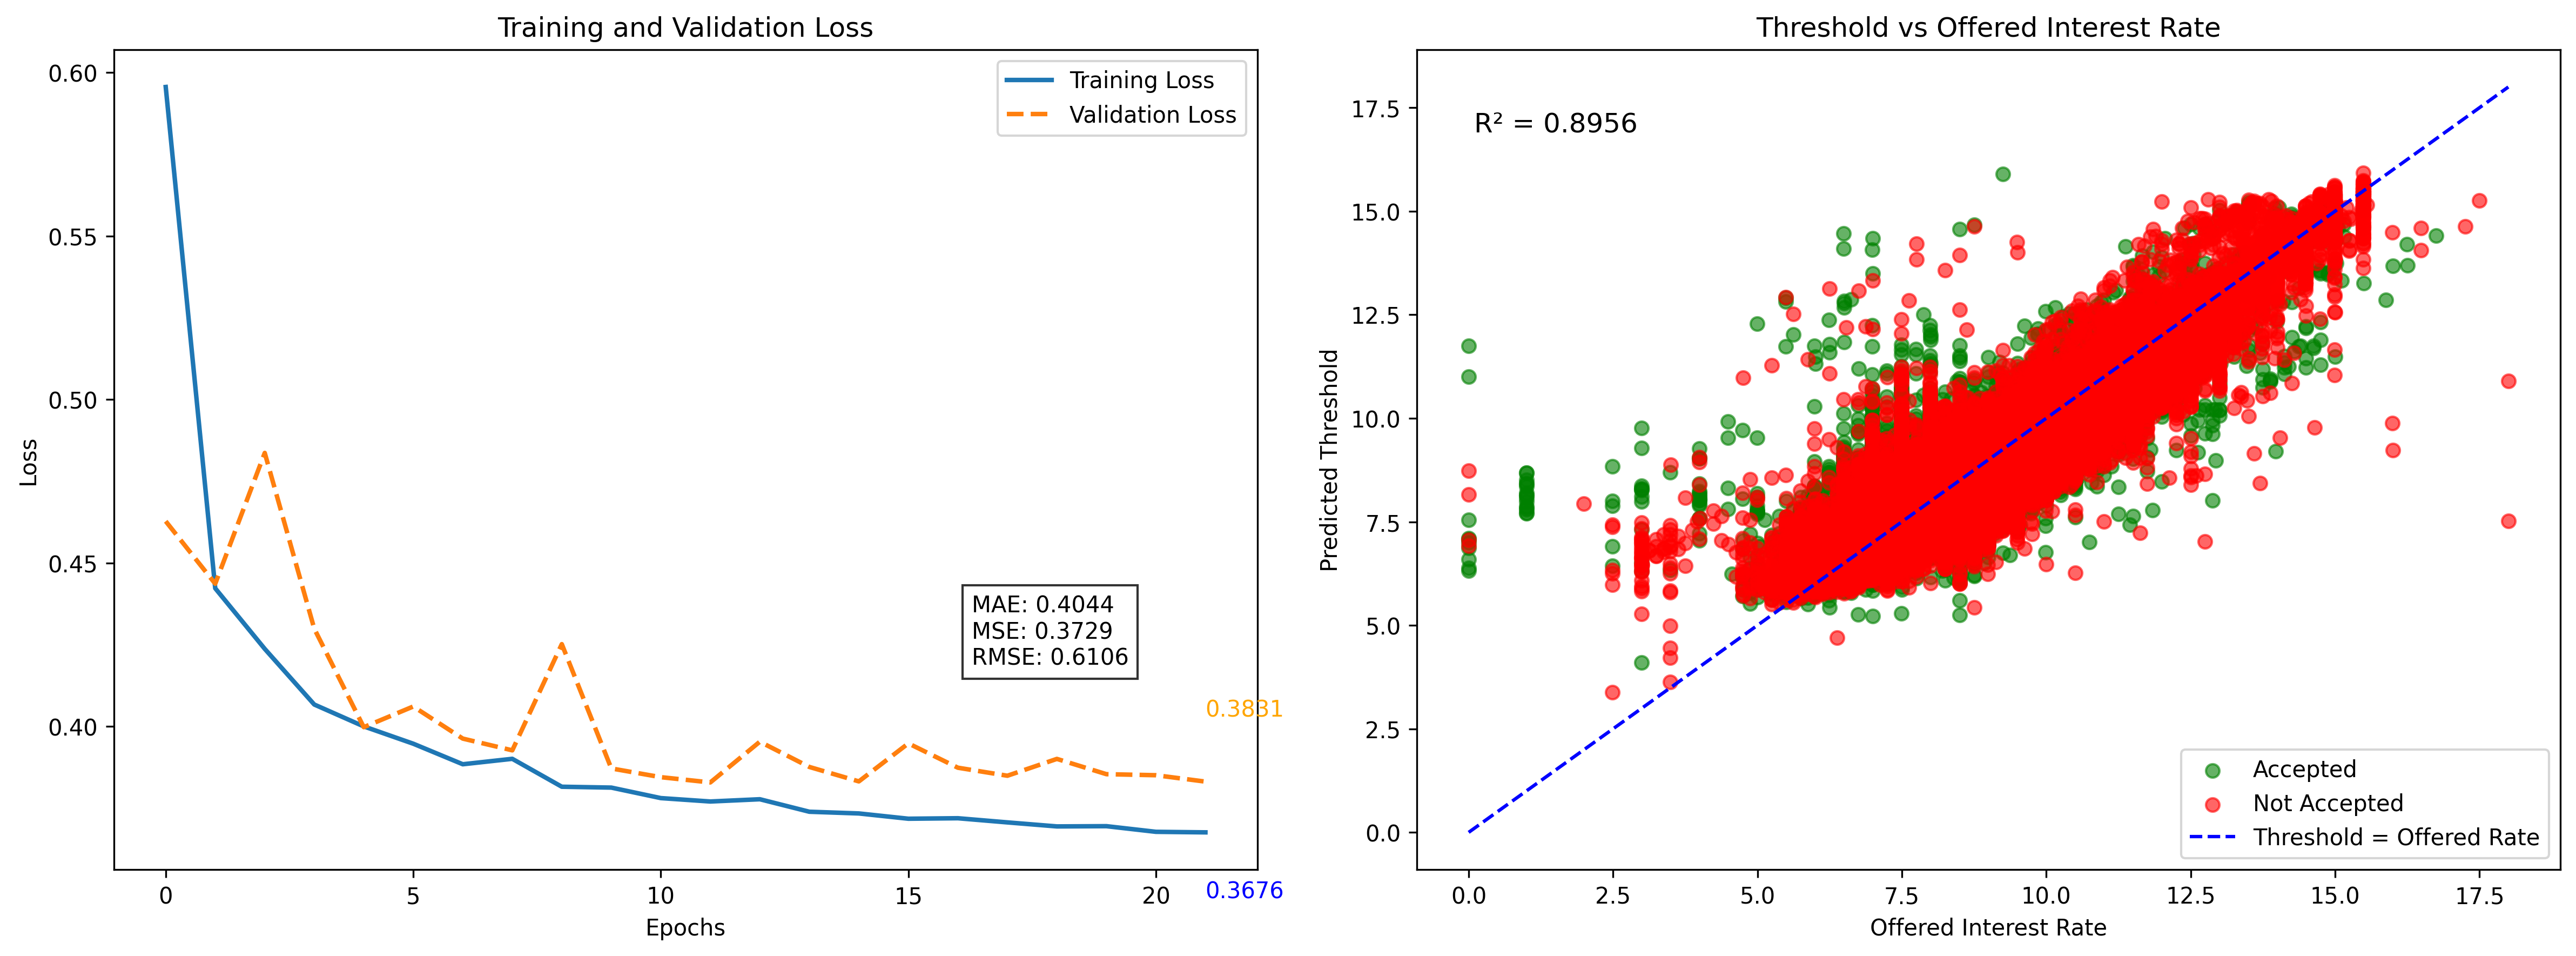

In [71]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

mae = mean_absolute_error(y_test, predicted_interest_rate)
mse = mean_squared_error(y_test, predicted_interest_rate)
rmse = np.sqrt(mse)

offered_rate = df_model.loc[test_idx, 'interest_rate'].values
acceptance = df_model.loc[test_idx, 'action_taken'].values
predicted_threshold = predicted_interest_rate.flatten()

r2 = r2_score(offered_rate, predicted_threshold)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

axes[0].plot(training_loss, label='Training Loss', linewidth=2)
axes[0].plot(validation_loss, label='Validation Loss', linewidth=2, linestyle='dashed')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].text(len(training_loss)-1, training_loss[-1]-0.02, f'{training_loss[-1]:.4f}', fontsize=10, color='blue')
axes[0].text(len(validation_loss)-1, validation_loss[-1]+0.02, f'{validation_loss[-1]:.4f}', fontsize=10, color='orange')
metrics_text = f"MAE: {mae:.4f}\nMSE: {mse:.4f}\nRMSE: {rmse:.4f}"
axes[0].text(0.75, 0.25, metrics_text, transform=axes[0].transAxes, fontsize=10,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
axes[0].legend()

axes[1].scatter(offered_rate[acceptance == 1], predicted_threshold[acceptance == 1],
                color='green', label='Accepted', alpha=0.6)
axes[1].scatter(offered_rate[acceptance == 0], predicted_threshold[acceptance == 0],
                color='red', label='Not Accepted', alpha=0.6)
axes[1].plot([min(offered_rate), max(offered_rate)], [min(offered_rate), max(offered_rate)],
             color='blue', linestyle='--', label='Threshold = Offered Rate')
axes[1].text(0.05, 0.9, f'R² = {r2:.4f}', transform=axes[1].transAxes, fontsize=12, color='black')
axes[1].set_xlabel('Offered Interest Rate')
axes[1].set_ylabel('Predicted Threshold')
axes[1].set_title('Threshold vs Offered Interest Rate')
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
#plt.savefig("combined_plots.png", dpi=300, bbox_inches='tight')
plt.show()


In [73]:
predicted_interest_rate = best_model.predict(X_test_scaled).flatten()
offered_rate_test = df_model.loc[test_idx, 'interest_rate'].values
y_acceptance = df_model.loc[test_idx, 'action_taken'].values

rate_spread = df_model.loc[test_idx, 'rate_spread'].values
property_value = df_model.loc[test_idx, 'property_value'].values
affordability = df_model.loc[test_idx, 'affordability_ratio'].values
applicant_age = df_model.loc[test_idx, 'applicant_age'].values
down_payment_ratio = df_model.loc[test_idx, 'down_payment_ratio'].values
#not_accepted_rate = df_model.loc[test_idx, 'not_accepted_rate'].values

log_features_values = np.column_stack([
    np.log(df_model.loc[test_idx, 'income'].values),
    np.log(df_model.loc[test_idx, 'loan_amount'].values)
])

df_encoded = pd.get_dummies(df_model, columns=['loan_type', 'loan_purpose', 'ltv_category'], drop_first=True)
loan_type_encoded = df_encoded.loc[test_idx, df_encoded.columns.str.startswith('loan_type_')].values
loan_purpose_encoded = df_encoded.loc[test_idx, df_encoded.columns.str.startswith('loan_purpose_')].values
ltv_category_encoded = df_encoded.loc[test_idx, df_encoded.columns.str.startswith('ltv_category_')].values
X_acceptance = np.column_stack((
    predicted_interest_rate,
    offered_rate_test,
    rate_spread,
    affordability,
    property_value,
    applicant_age,
    down_payment_ratio,
    log_features_values,
    ltv_category_encoded,
    loan_type_encoded,
    loan_purpose_encoded))


3409/3409 [==============================] - 1s 187us/step


In [74]:
# Step 2: Split classification data
X_acceptance_train, X_acceptance_test, y_acceptance_train, y_acceptance_test, acceptance_train_idx, acceptance_test_idx = train_test_split(
    X_acceptance, y_acceptance, test_idx, test_size=0.2, random_state=42)

X_acceptance_train = pd.DataFrame(X_acceptance_train).reset_index(drop=True)
X_acceptance_test = pd.DataFrame(X_acceptance_test).reset_index(drop=True)

X_acceptance_train['original_index'] = df_model.loc[acceptance_train_idx, 'original_index'].values
X_acceptance_test['original_index'] = df_model.loc[acceptance_test_idx, 'original_index'].values

# Step 3: Scale features
scaler_acceptance = StandardScaler()
X_acceptance_train_scaled = scaler_acceptance.fit_transform(X_acceptance_train.drop(columns=['original_index']))
X_acceptance_test_scaled = scaler_acceptance.transform(X_acceptance_test.drop(columns=['original_index']))

# Convert labels
y_acceptance_train = np.array(y_acceptance_train)
y_acceptance_test = np.array(y_acceptance_test)

# Step 4: Define and train the model
classification_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_acceptance_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = classification_model.fit(
    X_acceptance_train_scaled, y_acceptance_train,
    epochs=50, batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
2182/2182 [==============================] - 1s 431us/step - loss: 0.6437 - accuracy: 0.6193 - val_loss: 0.6384 - val_accuracy: 0.6252
Epoch 2/50
2182/2182 [==============================] - 1s 413us/step - loss: 0.6367 - accuracy: 0.6273 - val_loss: 0.6387 - val_accuracy: 0.6240
Epoch 3/50
2182/2182 [==============================] - 1s 410us/step - loss: 0.6337 - accuracy: 0.6292 - val_loss: 0.6354 - val_accuracy: 0.6291
Epoch 4/50
2182/2182 [==============================] - 1s 412us/step - loss: 0.6315 - accuracy: 0.6328 - val_loss: 0.6316 - val_accuracy: 0.6354
Epoch 5/50
2182/2182 [==============================] - 1s 412us/step - loss: 0.6297 - accuracy: 0.6335 - val_loss: 0.6312 - val_accuracy: 0.6307
Epoch 6/50
2182/2182 [==============================] - 1s 409us/step - loss: 0.6277 - accuracy: 0.6358 - val_loss: 0.6294 - val_accuracy: 0.6331
Epoch 7/50
2182/2182 [==============================] - 1s 409us/step - loss: 0.6254 - accuracy: 0.6371 - val_loss: 0.6282 -

In [75]:
# Step 5: Evaluate the classification model
test_loss, test_accuracy = classification_model.evaluate(X_acceptance_test_scaled, y_acceptance_test, verbose=1)
print(f"Test Loss (Classification Model): {test_loss}")
print(f"Test Accuracy (Classification Model): {test_accuracy}")


682/682 [==============================] - 0s 206us/step - loss: 0.6192 - accuracy: 0.6475
Test Loss (Classification Model): 0.6191927790641785
Test Accuracy (Classification Model): 0.6475037932395935


682/682 [==============================] - 0s 195us/step


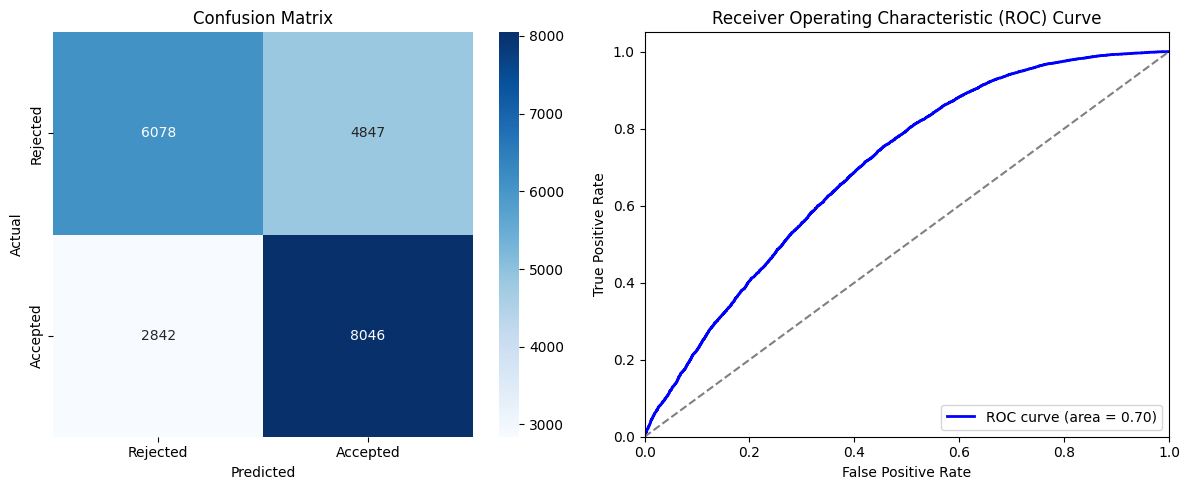

In [76]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
y_pred_prob = classification_model.predict(X_acceptance_test_scaled).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

report = classification_report(y_acceptance_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

conf_matrix = confusion_matrix(y_acceptance_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Rejected', 'Accepted'], yticklabels=['Rejected', 'Accepted'], ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

fpr, tpr, _ = roc_curve(y_acceptance_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[1].legend(loc='lower right')

plt.tight_layout()
#plt.savefig("classification_results.png")
plt.show()


In [77]:
y_pred = classification_model.predict(X_acceptance_test_scaled).flatten()
top_10_indices = np.argsort(y_pred)[-10:]
bottom_10_indices = np.argsort(y_pred)[:10]

top_10_original_indices = acceptance_test_idx[top_10_indices]
bottom_10_original_indices = acceptance_test_idx[bottom_10_indices]

rows_from_X_acceptance_test_high = X_acceptance_test.loc[X_acceptance_test['original_index'].isin(top_10_original_indices)]
rows_from_X_acceptance_test_low = X_acceptance_test.loc[X_acceptance_test['original_index'].isin(bottom_10_original_indices)]

rows_from_X_test_high = X_test.loc[X_test['original_index'].isin(top_10_original_indices)]
rows_from_X_test_low = X_test.loc[X_test['original_index'].isin(bottom_10_original_indices)]

rows_from_data_high = df_model.loc[top_10_original_indices]
rows_from_data_low = df_model.loc[bottom_10_original_indices]


682/682 [==============================] - 0s 217us/step


In [78]:
print(top_10_indices)

[13759  1939 14661 18791  3294  9508 20719 17787 16118 18431]


In [90]:
y_pred[13759]

0.95061004

In [80]:
print(bottom_10_indices)

[ 9779 14324   222 19348 10619 20904 14767  8049 12134  7826]


In [91]:
y_pred[9779]

0.00038609086

In [82]:
df_high = pd.DataFrame({
    'original_index': top_10_original_indices,
    'predicted_value': y_pred[top_10_indices]
}).merge(X_acceptance_test, on='original_index', how='left')\
  .merge(X_test, on='original_index', how='left', suffixes=('_acceptance', '_test'))\
  .merge(df_model, on='original_index', how='left', suffixes=('_test', '_data'))

df_low = pd.DataFrame({
    'original_index': bottom_10_original_indices,
    'predicted_value': y_pred[bottom_10_indices]
}).merge(X_acceptance_test, on='original_index', how='left')\
  .merge(X_test, on='original_index', how='left', suffixes=('_acceptance', '_test'))\
  .merge(df_model, on='original_index', how='left', suffixes=('_test', '_data'))


In [83]:
feature_names = [
    "predicted_interest_rate", "offered_rate_test", "rate_spread", "affordability",
    "property_value", "applicant_age", "down_payment_ratio",
    "log_income", "log_loan_amount"]


ltv_category_names = df_encoded.columns[df_encoded.columns.str.startswith('ltv_category_')].tolist()
loan_type_names = df_encoded.columns[df_encoded.columns.str.startswith('loan_type_')].tolist()
loan_purpose_names = df_encoded.columns[df_encoded.columns.str.startswith('loan_purpose_')].tolist()

feature_names += ltv_category_names + loan_type_names + loan_purpose_names


In [84]:
explainer = shap.Explainer(classification_model, X_acceptance_train_scaled, feature_names=feature_names)
shap_values = explainer(X_acceptance_test_scaled)


PermutationExplainer explainer: 21814it [06:38, 53.66it/s]                      


## highest probability of accepting a laon offer by a borrower 

In [85]:
rows_from_data_high

,loan_type,loan_purpose,lei,rate_spread,applicant_age,loan_term,property_value,loan_amount,interest_rate,action_taken,income,debt_to_income_ratio,down_payment,monthly_payment,down_payment_ratio,affordability_ratio,loan_to_value_ratio,risk_factor,normalized_risk_factor,ltv_category,original_index
196369,1,4,549300PIL8LFAQ04XC20,5.250,50.0,240.0,1285000.0,195000,11.750,1,1000.0,46.0,1090000.0,812.500000,0.848249,0.102564,0.151751,6.980545,0.002820,Low,196369
475089,1,4,549300PIL8LFAQ04XC20,6.297,50.0,360.0,665000.0,95000,16.250,1,1000.0,37.0,570000.0,263.888889,0.857143,0.315789,0.142857,5.285714,0.002136,Low,475089
299023,1,4,549300PIL8LFAQ04XC20,2.693,60.0,360.0,775000.0,75000,8.950,1,1000.0,33.0,700000.0,208.333333,0.903226,0.400000,0.096774,3.193548,0.001290,Low,299023
83223,1,4,549300PIL8LFAQ04XC20,3.224,40.0,360.0,1825000.0,105000,9.750,1,1000.0,41.0,1720000.0,291.666667,0.942466,0.285714,0.057534,2.358904,0.000953,Low,83223
196142,1,4,549300PIL8LFAQ04XC20,5.103,50.0,360.0,325000.0,55000,11.450,1,1000.0,40.0,270000.0,152.777778,0.830769,0.545455,0.169231,6.769231,0.002735,Low,196142
312507,1,4,549300PIL8LFAQ04XC20,2.914,50.0,360.0,585000.0,85000,9.375,1,1000.0,43.0,500000.0,236.111111,0.854701,0.352941,0.145299,6.247863,0.002524,Low,312507
76866,1,4,549300PIL8LFAQ04XC20,5.461,40.0,360.0,435000.0,45000,11.450,1,1000.0,39.0,390000.0,125.000000,0.896552,0.666667,0.103448,4.034483,0.001630,Low,76866
378132,1,4,549300PIL8LFAQ04XC20,3.756,40.0,360.0,515000.0,65000,9.950,1,1000.0,25.0,450000.0,180.555556,0.873786,0.461538,0.126214,3.155340,0.001275,Low,378132
518433,1,5,549300GMNBYF84V5RF83,0.220,70.0,240.0,345000.0,65000,8.500,1,138000.0,36.0,280000.0,270.833333,0.811594,42.461538,0.188406,6.782609,0.002740,Low,518433
494698,1,5,5493000XYE7QL54NMB52,1.270,30.0,84.0,255000.0,45000,7.500,1,73000.0,33.0,210000.0,535.714286,0.823529,11.355556,0.176471,5.823529,0.002353,Low,494698


### Factors impacting this decisoin explained by SHAP

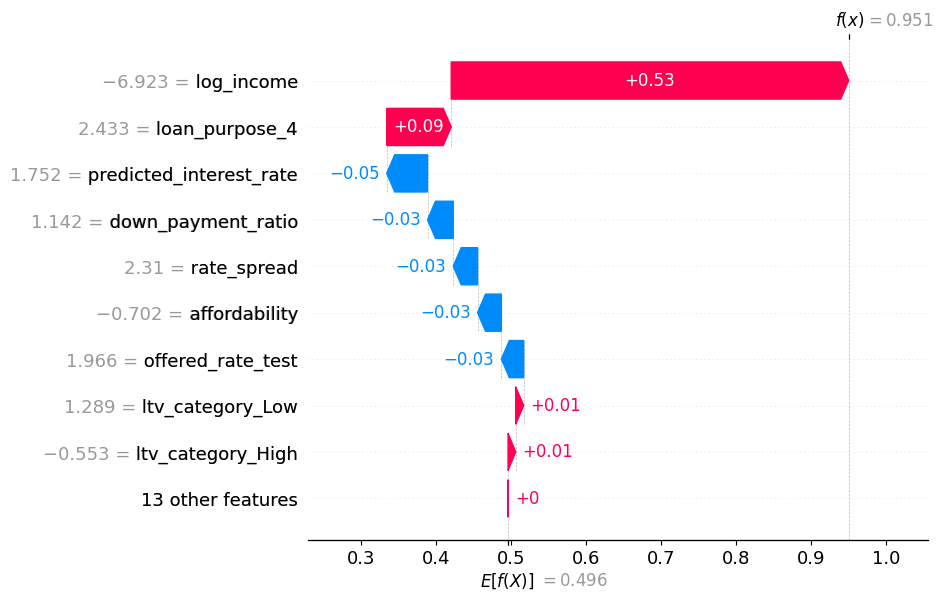

In [92]:
plt.figure()
shap.plots.waterfall(shap_values[13759])
plt.close()
plt.show()


## Lowest probability of accepting a laon offer by a borrower 

In [87]:
rows_from_data_low

,loan_type,loan_purpose,lei,rate_spread,applicant_age,loan_term,property_value,loan_amount,interest_rate,action_taken,income,debt_to_income_ratio,down_payment,monthly_payment,down_payment_ratio,affordability_ratio,loan_to_value_ratio,risk_factor,normalized_risk_factor,ltv_category,original_index
56126,1,4,5493001GCBD5XGNIC815,3.28,40.0,180.0,4555000.0,5000,11.49,0,90000.0,10.0,4550000.0,27.777778,0.998902,270.000000,0.001098,0.010977,0.000004,0,56126
468753,1,4,5493001GCBD5XGNIC815,3.00,50.0,180.0,1705000.0,15000,10.99,0,135000.0,55.0,1690000.0,83.333333,0.991202,135.000000,0.008798,0.483871,0.000195,0,468753
256548,1,4,5493001GCBD5XGNIC815,4.81,70.0,180.0,2295000.0,45000,12.99,0,70000.0,55.0,2250000.0,250.000000,0.980392,23.333333,0.019608,1.078431,0.000436,Low,256548
7168,1,4,5493001GCBD5XGNIC815,6.84,50.0,180.0,275000.0,85000,14.99,0,105000.0,55.0,190000.0,472.222222,0.690909,18.529412,0.309091,17.000000,0.006869,Low,7168
24070,1,4,5493001GCBD5XGNIC815,6.52,40.0,182.0,1925000.0,15000,14.74,0,162000.0,46.0,1910000.0,82.417582,0.992208,163.800000,0.007792,0.358442,0.000145,0,24070
186612,1,4,5493001GCBD5XGNIC815,6.59,50.0,180.0,4415000.0,105000,14.74,0,500000.0,44.0,4310000.0,583.333333,0.976217,71.428571,0.023783,1.046433,0.000423,Low,186612
96448,1,4,5493001GCBD5XGNIC815,6.70,60.0,180.0,505000.0,85000,14.99,0,145000.0,55.0,420000.0,472.222222,0.831683,25.588235,0.168317,9.257426,0.003740,Low,96448
157682,1,4,5493001GCBD5XGNIC815,5.82,70.0,180.0,3665000.0,95000,13.99,0,104000.0,55.0,3570000.0,527.777778,0.974079,16.421053,0.025921,1.425648,0.000576,Low,157682
414129,1,4,5493001GCBD5XGNIC815,7.39,40.0,182.0,515000.0,5000,15.49,0,159000.0,55.0,510000.0,27.472527,0.990291,482.300000,0.009709,0.533981,0.000216,0,414129
404089,1,4,5493001GCBD5XGNIC815,3.92,50.0,180.0,1775000.0,105000,12.24,0,275000.0,55.0,1670000.0,583.333333,0.940845,39.285714,0.059155,3.253521,0.001314,Low,404089


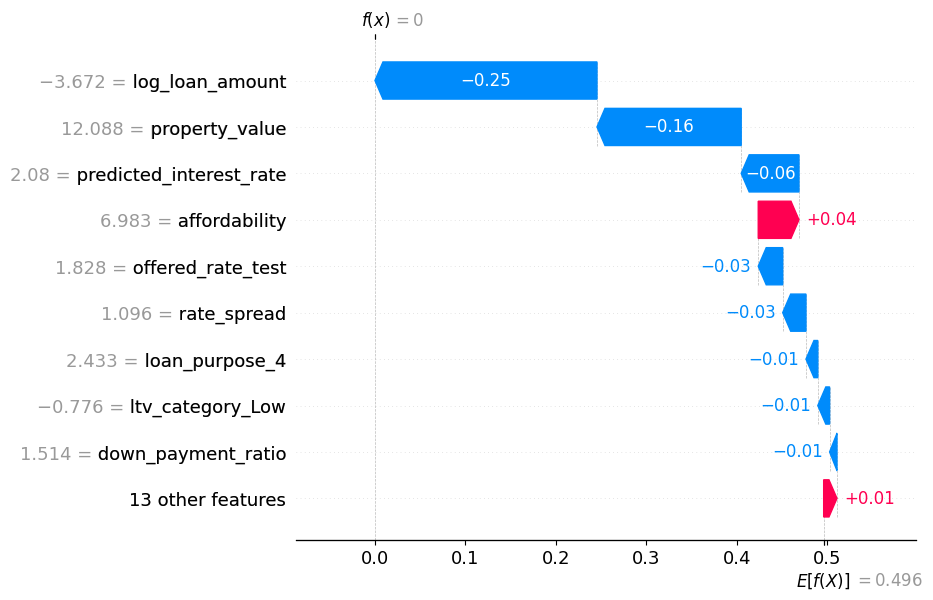

In [93]:
plt.figure()
shap.plots.waterfall(shap_values[9779])
plt.close()
plt.show()